# Compensation for a non-linear charge sensor

We analyse the effect of a non-linear sensing dot on the value for the tunnel coupling obtained from the fitting of an inter-dot transition line. The sensing dot shape is simulated based on a Gaussian, while the data of the inter-dot transition is experimental data.

First we load all necessary packages

In [1]:
import os
import qcodes
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy

from qcodes.data.hdf5_format import HDF5Format

import qtt
import qtt.pgeometry
from qtt.data import load_example_dataset
from qtt.algorithms.functions import gaussian
from qtt.algorithms.tunneling import polmod_all_2slopes, fit_pol_all
from qtt.algorithms.chargesensor import DataLinearizer, correctChargeSensor
%matplotlib inline

np.set_printoptions(suppress=True, precision=3)

In [2]:
def show_pol_fit(delta, signal, par_fit, fig=1):
    """ Show data of a polarization fit """
    plt.figure(fig)
    plt.clf()
    plt.plot(delta, signal, 'bo')
    plt.plot(delta, polmod_all_2slopes(delta, par_fit, kT), 'r')
    plt.title('Tunnel coupling: %.2f (ueV) = %.2f (GHz)' %
              (par_fit[0], par_fit[0] / h))
    plt.xlabel('Difference in chemical potentials (ueV)')
    _ = plt.ylabel('Signal (a.u.)')

Define physical constants and parameters

In [3]:
h = 1e9*scipy.constants.h/(1e-6*scipy.constants.elementary_charge)  # Planck's constant in units [ueV/GHz]
kb = scipy.constants.k/(1e-6*scipy.constants.elementary_charge)  # [ueV/K], Boltzmann constant
kT = 10e-3 * kb  # effective electron temperature in ueV

### Load example dataset and define signal of charge sensor

In [4]:
dataset = load_example_dataset('2017-02-21/15-59-56')

signal = np.array(dataset.default_parameter_array('signal'))
delta = np.array(dataset.default_parameter_array('signal').set_arrays[0])

# Define signal of the sensing dot
xs = np.arange(-600, 0, 3.)
ys = gaussian(xs, -300, std=70, amplitude=510, offset=2)
ys = gaussian(xs, -300, std=70, amplitude=510, offset=20)

### Find range of sensing dot used

The correction to the non-linearity of the charge sensor is done by fitting a linear function in the region of interest.

fitCoulombPeaks: peak 0: position -300.00 max 530.00 valid 1
filterPeaks: 1 -> 1 good peaks
peakScores: noise factor 1.00
peakScores: 0: height 268.3 halfwidth 27.0, score 144.87


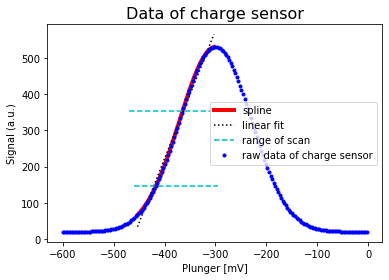

In [5]:
dl, results = correctChargeSensor(delta, signal, xs, ys, fig=100)
plt.plot(xs, ys, '.b', label='raw data of charge sensor')
plt.legend()
plt.title('Data of charge sensor', fontsize=16)
_ = plt.xlabel('Plunger [mV]')
_ = plt.ylabel('Signal (a.u.)')

Determine the corrected data points

In [6]:
xsignal = dl.backward_curve(signal)
signal_corrected = dl.forward(xsignal)  # make sure data is in similar range

### Fit the polarization line

The effect of the non-linear charge sensor is a 5% error in the estimated tunnel coupling.

tunnel coupling: 4.9 [GHz]
tunnel coupling with compensation: 5.2 [GHz]


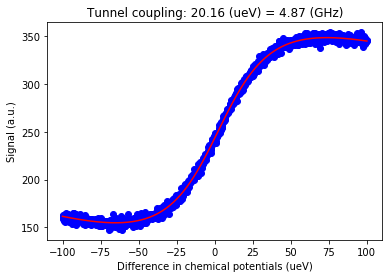

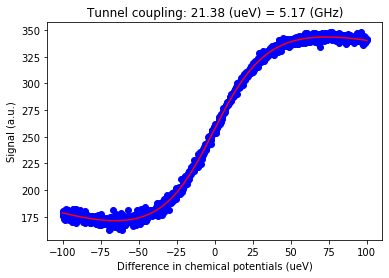

In [7]:
par_fit,_ , _ = fit_pol_all(delta, signal, kT, par_guess=None)
show_pol_fit(delta, signal, par_fit, fig=1)

par_fit_corrected, _, _ = fit_pol_all(delta, signal_corrected, kT)
show_pol_fit(delta, signal_corrected, par_fit_corrected, fig=2)

print('tunnel coupling: %.1f [GHz]' % (par_fit[0] / h))
print('tunnel coupling with compensation: %.1f [GHz]' % (par_fit_corrected[0] / h))

In [8]:
print('### fitted parameters ###')
print(par_fit)
print(par_fit_corrected)

### fitted parameters ###
[ 20.16    1.969  99.64   -0.505  -0.442 300.373]
[ 21.38   -1.59  112.843  -0.558  -0.406 280.184]
